In [5]:
!pip install -U sentence-transformers huggingface-hub hf_transfer  pandas numpy scikit-learn matplotlib seaborn tqdm sentence-transformers

!pip install --upgrade numpy>=2.0.0

!ls

  Using cached huggingface_hub-1.1.4-py3-none-any.whl.metadata (13 kB)
'=2.0.0'
 Untitled.ipynb
 __pycache__
 download_status_with_tags.csv
 gemini25flash
 gemini25flash.7z
 gemini25flash_preprocessed
 gemini25flash_preprocessed_stopwords
 get_data.ipynb
 model_test.ipynb
 results_all_tags_above_10
 stopwords-kz.txt
 stopwords-ru.txt
 tags_above_10_nopreprocess.ipynb
 tags_above_10_preprocessed-stopwords.ipynb
 tags_above_10_preprocessed.ipynb
 text_selector.py
 token_analysis_preprocessed


Loading data from: /workspace/embeddings/download_status_with_tags.csv
Found 564 unique documents
Loading EmbeddingGemma tokenizer...
Tokenizer loaded. Vocab size: 262144


Analyzing documents:  42%|████▏     | 235/564 [00:06<00:04, 72.11it/s]

Skipping 'Лицензия генеральной проектной и субпроектной орга...' - [Errno 36] File name too long: '/workspace/embeddings/gemini25flash_preprocessed_stopwords/Лицензия генеральной проектной и субпроектной организаций с приложениями к ней и указанием категории лицензиата, дающих право на данный вид проектной деятельности_1'


Analyzing documents:  71%|███████   | 400/564 [00:16<00:05, 28.80it/s]

Skipping 'Разрешение местных исполнительных органов на испол...' - [Errno 36] File name too long: '/workspace/embeddings/gemini25flash_preprocessed_stopwords/Разрешение местных исполнительных органов на использование земельного участка (площади, трассы) или правоустанавливающий документ на земельный участок_1'
Skipping 'Разрешение местных исполнительных органов на испол...' - [Errno 36] File name too long: '/workspace/embeddings/gemini25flash_preprocessed_stopwords/Разрешение местных исполнительных органов на использование земельного участка (площади, трассы) или правоустанавливающий документ на земельный участок_10'
Skipping 'Разрешение местных исполнительных органов на испол...' - [Errno 36] File name too long: '/workspace/embeddings/gemini25flash_preprocessed_stopwords/Разрешение местных исполнительных органов на использование земельного участка (площади, трассы) или правоустанавливающий документ на земельный участок_2'
Skipping 'Разрешение местных исполнительных органов на испол...

Analyzing documents: 100%|██████████| 564/564 [00:25<00:00, 22.20it/s]



TOKEN ANALYSIS SUMMARY

Total documents analyzed: 504
Max sequence length: 2048 tokens

--- Truncation Statistics ---
Documents truncated: 257 / 504 (51.0%)
Average tokens lost: 15788
Max tokens lost: 232182
Average % truncated: 60.7%

--- Token Distribution ---
Mean tokens per document: 9542
Median tokens per document: 2139
Min tokens: 89
Max tokens: 234230
Std dev: 22983

--- Percentiles ---
  25th percentile: 845 tokens ✓
  50th percentile: 2139 tokens ✗ TRUNCATED
  75th percentile: 5643 tokens ✗ TRUNCATED
  90th percentile: 23224 tokens ✗ TRUNCATED
  95th percentile: 56185 tokens ✗ TRUNCATED
  99th percentile: 123518 tokens ✗ TRUNCATED

--- Characters per Token ---
Average: 2.83
This means ~5804 chars fit in 2048 tokens

--- Per-Page Statistics ---
Average tokens per page: 618
Max tokens in single page: 15661

--- Truncation Happens At ---
Average page: 4.6
Median page: 4
  Page 1: 6 documents
  Page 2: 21 documents
  Page 3: 52 documents
  Page 4: 56 documents
  Page 5: 40 docume

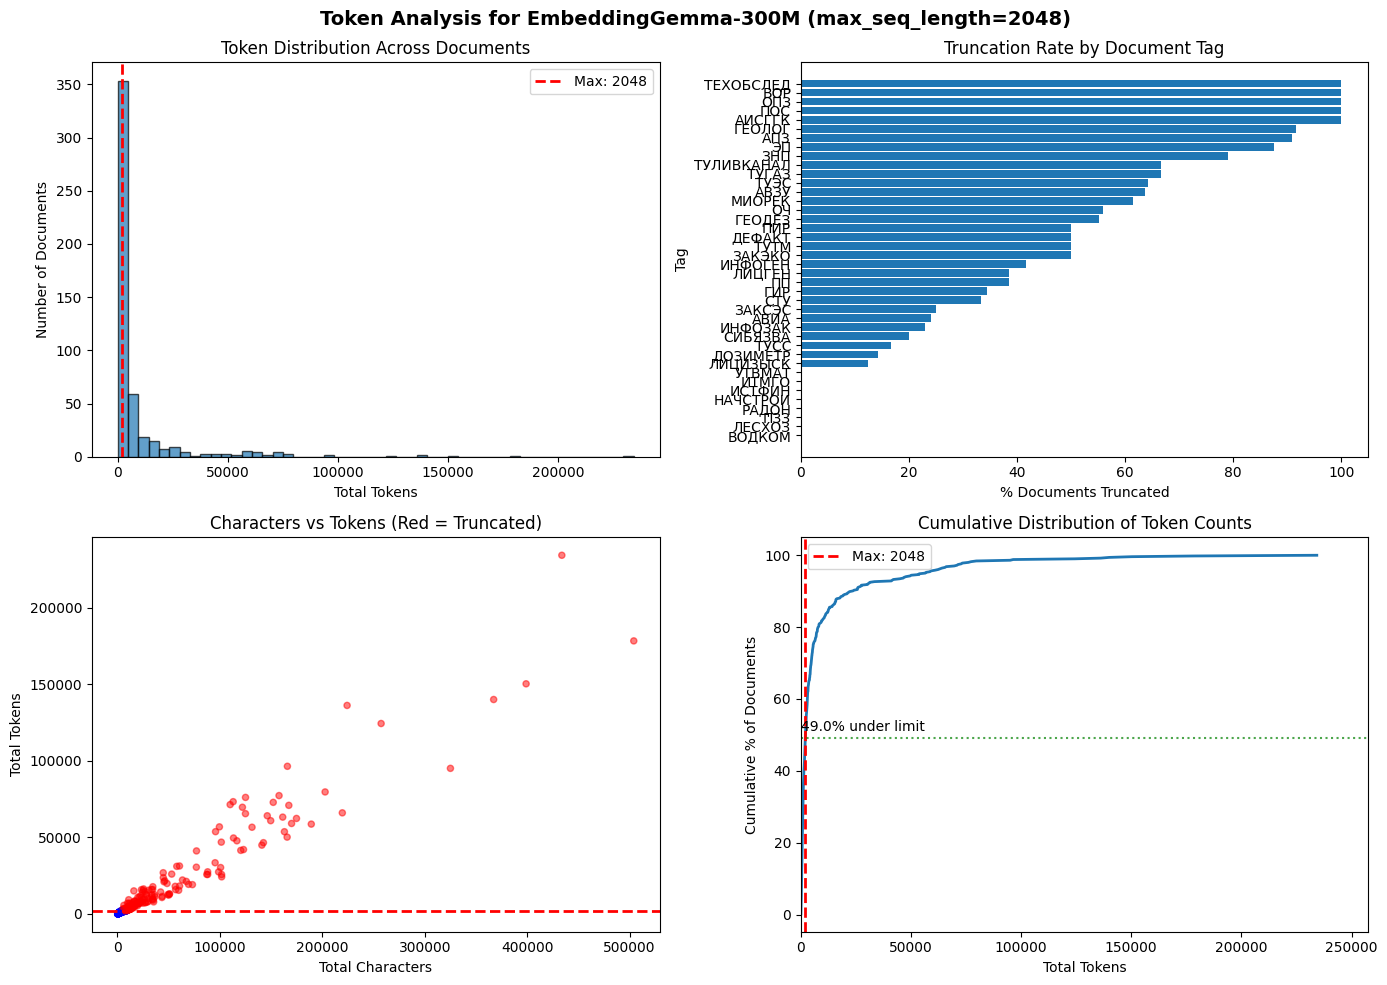


TOP 10 MOST TRUNCATED DOCUMENTS
                                      doc_name    tag  total_tokens  tokens_lost  percent_truncated
Материалы инженерно-геологических изысканий _3 ГЕОЛОГ        234230       232182          99.125646
                         Тестовые файлы ОПЗ_16    ОПЗ        178308       176260          98.851426
                  Задание на проектирование _7    ЗНП        150286       148238          98.637265
                                      ПСД.ЭП_5     ЭП        140029       137981          98.537446
 Материалы инженерно-геологических изысканий_1 ГЕОЛОГ        136165       134117          98.495942
                     Ведомость объемов работ_1    ВОР        124356       122308          98.353115
Материалы инженерно-геологических изысканий_10 ГЕОЛОГ         96413        94365          97.875805
                          Тестовые файлы ОПЗ_1    ОПЗ         95072        93024          97.845843
                                    ПСД.ОВОС_7    ПОС         79665

In [7]:
"""
Token Counter for Documents

Analyzes token counts per document and per page to understand truncation impact
with EmbeddingGemma-300M (max_seq_length = 2048 tokens).
"""

import json
import pandas as pd
import numpy as np
from pathlib import Path
from transformers import AutoTokenizer
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration
GE_EXPERIMENTS_ROOT = Path.cwd()
BASE_DIR = GE_EXPERIMENTS_ROOT / "gemini25flash_preprocessed_stopwords"
CSV_PATH = GE_EXPERIMENTS_ROOT / "download_status_with_tags.csv"
RESULTS_DIR = GE_EXPERIMENTS_ROOT / "token_analysis_preprocessed"
RESULTS_DIR.mkdir(exist_ok=True)

# EmbeddingGemma max sequence length
MAX_SEQ_LENGTH = 2048

def load_tokenizer():
    """Load the EmbeddingGemma tokenizer."""
    print("Loading EmbeddingGemma tokenizer...")
    tokenizer = AutoTokenizer.from_pretrained("google/embeddinggemma-300M")
    print(f"Tokenizer loaded. Vocab size: {tokenizer.vocab_size}")
    return tokenizer

def load_document_pages(doc_name: str) -> list:
    """Load all pages from a document folder containing numbered JSON files."""
    doc_folder = BASE_DIR / doc_name

    try:
        if not doc_folder.exists() or not doc_folder.is_dir():
            return []
    except OSError as e:
        # Handle filename too long or other OS errors
        print(f"Skipping '{doc_name[:50]}...' - {e}")
        return []

    try:
        # Get all JSON files and sort by page number
        json_files = list(doc_folder.glob("*.json"))
        json_files.sort(key=lambda x: int(x.stem) if x.stem.isdigit() else 0)

        pages = []
        for page_file in json_files:
            try:
                with open(page_file, 'r', encoding='utf-8') as f:
                    data = json.load(f)
                    text = data.get('text', '')
                    if text:
                        pages.append(text)
            except Exception as e:
                print(f"Error loading {page_file}: {e}")
                continue

        return pages
    except Exception as e:
        print(f"Error loading {doc_name[:50]}...: {e}")
        return []

def count_tokens(tokenizer, text: str) -> int:
    """Count tokens in a text string."""
    if not text or not text.strip():
        return 0
    return len(tokenizer.encode(text, add_special_tokens=False))

def analyze_documents(tokenizer, df: pd.DataFrame) -> pd.DataFrame:
    """Analyze token counts for all documents."""
    results = []

    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Analyzing documents"):
        doc_name = row['doc_name']
        tag = row['document_tag']

        pages = load_document_pages(doc_name)

        if not pages:
            continue

        # Count tokens per page
        page_tokens = [count_tokens(tokenizer, page) for page in pages]
        total_tokens = sum(page_tokens)

        # Calculate cumulative tokens (for understanding where truncation happens)
        cumulative_tokens = np.cumsum(page_tokens)

        # Find which page causes truncation
        truncation_page = None
        for i, cum in enumerate(cumulative_tokens):
            if cum > MAX_SEQ_LENGTH:
                truncation_page = i + 1  # 1-indexed
                break

        # Character counts for comparison
        page_chars = [len(page) for page in pages]
        total_chars = sum(page_chars)

        results.append({
            'doc_name': doc_name,
            'tag': tag,
            'num_pages': len(pages),
            'total_tokens': total_tokens,
            'total_chars': total_chars,
            'tokens_per_page': page_tokens,
            'chars_per_page': page_chars,
            'avg_tokens_per_page': np.mean(page_tokens) if page_tokens else 0,
            'max_tokens_single_page': max(page_tokens) if page_tokens else 0,
            'truncation_page': truncation_page,
            'tokens_lost': max(0, total_tokens - MAX_SEQ_LENGTH),
            'percent_truncated': max(0, (total_tokens - MAX_SEQ_LENGTH) / total_tokens * 100) if total_tokens > 0 else 0,
            'is_truncated': total_tokens > MAX_SEQ_LENGTH,
            'chars_per_token': total_chars / total_tokens if total_tokens > 0 else 0,
        })

    return pd.DataFrame(results)

def print_summary(results_df: pd.DataFrame):
    """Print summary statistics."""
    print("\n" + "="*80)
    print("TOKEN ANALYSIS SUMMARY")
    print("="*80)

    print(f"\nTotal documents analyzed: {len(results_df)}")
    print(f"Max sequence length: {MAX_SEQ_LENGTH} tokens")

    # Truncation stats
    truncated = results_df[results_df['is_truncated']]
    print(f"\n--- Truncation Statistics ---")
    print(f"Documents truncated: {len(truncated)} / {len(results_df)} ({len(truncated)/len(results_df)*100:.1f}%)")

    if len(truncated) > 0:
        print(f"Average tokens lost: {truncated['tokens_lost'].mean():.0f}")
        print(f"Max tokens lost: {truncated['tokens_lost'].max():.0f}")
        print(f"Average % truncated: {truncated['percent_truncated'].mean():.1f}%")

    # Token distribution
    print(f"\n--- Token Distribution ---")
    print(f"Mean tokens per document: {results_df['total_tokens'].mean():.0f}")
    print(f"Median tokens per document: {results_df['total_tokens'].median():.0f}")
    print(f"Min tokens: {results_df['total_tokens'].min():.0f}")
    print(f"Max tokens: {results_df['total_tokens'].max():.0f}")
    print(f"Std dev: {results_df['total_tokens'].std():.0f}")

    # Percentiles
    print(f"\n--- Percentiles ---")
    for p in [25, 50, 75, 90, 95, 99]:
        val = results_df['total_tokens'].quantile(p/100)
        status = "✓" if val <= MAX_SEQ_LENGTH else "✗ TRUNCATED"
        print(f"  {p}th percentile: {val:.0f} tokens {status}")

    # Characters per token ratio
    print(f"\n--- Characters per Token ---")
    print(f"Average: {results_df['chars_per_token'].mean():.2f}")
    print(f"This means ~{MAX_SEQ_LENGTH * results_df['chars_per_token'].mean():.0f} chars fit in {MAX_SEQ_LENGTH} tokens")

    # Per-page analysis
    print(f"\n--- Per-Page Statistics ---")
    print(f"Average tokens per page: {results_df['avg_tokens_per_page'].mean():.0f}")
    print(f"Max tokens in single page: {results_df['max_tokens_single_page'].max():.0f}")

    # Truncation page distribution
    truncation_pages = results_df[results_df['truncation_page'].notna()]['truncation_page']
    if len(truncation_pages) > 0:
        print(f"\n--- Truncation Happens At ---")
        print(f"Average page: {truncation_pages.mean():.1f}")
        print(f"Median page: {truncation_pages.median():.0f}")
        for page_num in sorted(truncation_pages.unique())[:10]:
            count = (truncation_pages == page_num).sum()
            print(f"  Page {int(page_num)}: {count} documents")

def create_visualizations(results_df: pd.DataFrame):
    """Create visualization plots."""
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle('Token Analysis for EmbeddingGemma-300M (max_seq_length=2048)', fontsize=14, fontweight='bold')

    # 1. Token distribution histogram
    ax1 = axes[0, 0]
    ax1.hist(results_df['total_tokens'], bins=50, edgecolor='black', alpha=0.7)
    ax1.axvline(x=MAX_SEQ_LENGTH, color='red', linestyle='--', linewidth=2, label=f'Max: {MAX_SEQ_LENGTH}')
    ax1.set_xlabel('Total Tokens')
    ax1.set_ylabel('Number of Documents')
    ax1.set_title('Token Distribution Across Documents')
    ax1.legend()

    # 2. Truncation percentage by tag
    ax2 = axes[0, 1]
    tag_truncation = results_df.groupby('tag')['is_truncated'].mean() * 100
    tag_truncation = tag_truncation.sort_values(ascending=True)
    bars = ax2.barh(tag_truncation.index, tag_truncation.values)
    ax2.set_xlabel('% Documents Truncated')
    ax2.set_ylabel('Tag')
    ax2.set_title('Truncation Rate by Document Tag')

    # 3. Tokens vs Characters scatter
    ax3 = axes[1, 0]
    colors = ['red' if t else 'blue' for t in results_df['is_truncated']]
    ax3.scatter(results_df['total_chars'], results_df['total_tokens'], c=colors, alpha=0.5, s=20)
    ax3.axhline(y=MAX_SEQ_LENGTH, color='red', linestyle='--', linewidth=2)
    ax3.set_xlabel('Total Characters')
    ax3.set_ylabel('Total Tokens')
    ax3.set_title('Characters vs Tokens (Red = Truncated)')

    # 4. Cumulative distribution
    ax4 = axes[1, 1]
    sorted_tokens = np.sort(results_df['total_tokens'])
    cumulative = np.arange(1, len(sorted_tokens) + 1) / len(sorted_tokens) * 100
    ax4.plot(sorted_tokens, cumulative, linewidth=2)
    ax4.axvline(x=MAX_SEQ_LENGTH, color='red', linestyle='--', linewidth=2, label=f'Max: {MAX_SEQ_LENGTH}')

    # Find percentage at max
    pct_under = (results_df['total_tokens'] <= MAX_SEQ_LENGTH).mean() * 100
    ax4.axhline(y=pct_under, color='green', linestyle=':', alpha=0.7)
    ax4.text(MAX_SEQ_LENGTH * 0.1, pct_under + 2, f'{pct_under:.1f}% under limit', fontsize=10)

    ax4.set_xlabel('Total Tokens')
    ax4.set_ylabel('Cumulative % of Documents')
    ax4.set_title('Cumulative Distribution of Token Counts')
    ax4.legend()
    ax4.set_xlim(0, results_df['total_tokens'].max() * 1.1)

    plt.tight_layout()
    plot_path = RESULTS_DIR / "token_analysis.png"
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    print(f"\nPlot saved to: {plot_path}")
    plt.show()

def main():
    # Load data
    print(f"Loading data from: {CSV_PATH}")
    df = pd.read_csv(CSV_PATH)
    df['doc_name'] = df['filename'].str.replace('.pdf', '', regex=False)
    unique_docs = df.drop_duplicates(subset=['doc_name'])
    print(f"Found {len(unique_docs)} unique documents")

    # Load tokenizer
    tokenizer = load_tokenizer()

    # Analyze documents
    results_df = analyze_documents(tokenizer, unique_docs)

    # Print summary
    print_summary(results_df)

    # Save detailed results
    csv_path = RESULTS_DIR / "token_counts_per_document.csv"

    # Save without the list columns for CSV
    save_df = results_df.drop(columns=['tokens_per_page', 'chars_per_page'])
    save_df.to_csv(csv_path, index=False)
    print(f"\nDetailed results saved to: {csv_path}")

    # Save full results with page-level data as JSON
    json_path = RESULTS_DIR / "token_counts_full.json"
    results_df.to_json(json_path, orient='records', indent=2)
    print(f"Full results (with per-page data) saved to: {json_path}")

    # Create visualizations
    create_visualizations(results_df)

    # Print worst offenders
    print("\n" + "="*80)
    print("TOP 10 MOST TRUNCATED DOCUMENTS")
    print("="*80)
    worst = results_df.nlargest(10, 'tokens_lost')[['doc_name', 'tag', 'total_tokens', 'tokens_lost', 'percent_truncated']]
    print(worst.to_string(index=False))

    return results_df

if __name__ == "__main__":
    results = main()
